 ARIMA Model : Auto regressive Integrated Moving Average(AR,I and MA)
 Steps:
      - Data should be sampled 
      - Should have Datetime index column. pd.DatetimeIndex can be used.
      - Time series data should be stationary. No Trend, Cycle, Seasionality 
              - Verification by Rolling Statistic Method or DickyFullder Test
      - Convert data to stationary 
              - Use differencing by shifting df.shift() or by seasonal shifting(weekly or monthly)
              - Use Transformations exp, log, or sqroot
              
      - Find p: ACF graph, d : for no of difference , q: PACF graph.
      - Use stats.tsa.arima_model.ARIMA to predict.
      - Convert the data back to original form(reverse the transformation)
      - Plot the predictions.
              

In [230]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
#Load Data
#denoised_data = pd.read_csv('/Users/soonam/Desktop/HKUST/Courses/MSBD5001/Project/denoised_data.csv')
all_features_label_data = pd.read_csv('/Users/soonam/Desktop/HKUST/Courses/MSBD5001/Project/label_data.csv')
df_arima = all_features_label_data['denoised_data']
df_arima.columns = ['price']

In [3]:
#convert 15 minutes to daily
df_arima_resampled = df_arima[df_arima.index % 96 == 0] 

In [140]:
df_arima_resampled.head()

2014-12-01    237.766210
2014-12-02    244.080548
2014-12-03    238.402581
2014-12-04    242.378760
2014-12-05    243.179597
Freq: B, Name: denoised_data, dtype: float64

In [169]:
#df_arima_resampled.plot()
df_arima_resampled.index = pd.DatetimeIndex(freq='B',start='2014-12-01',periods=1288)

In [171]:
df_arima_resampled.head()

2014-12-01    237.766210
2014-12-02    244.080548
2014-12-03    238.402581
2014-12-04    242.378760
2014-12-05    243.179597
Freq: B, Name: denoised_data, dtype: float64

#### Analysis of data for stationarity by different techniques

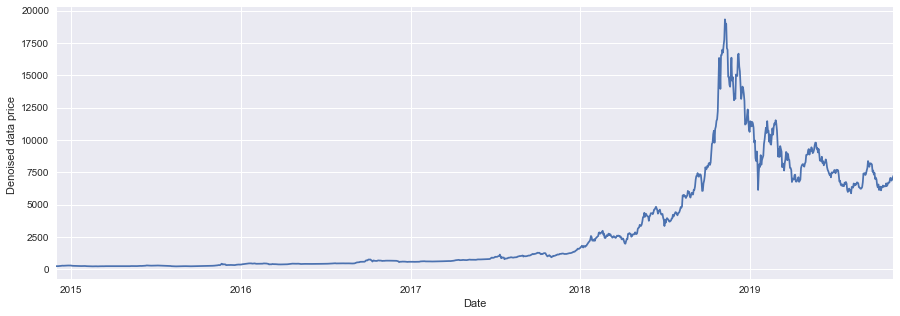

In [172]:
plt.ylabel('Denoised data price ')
plt.xlabel('Date')
df_arima_resampled.plot()

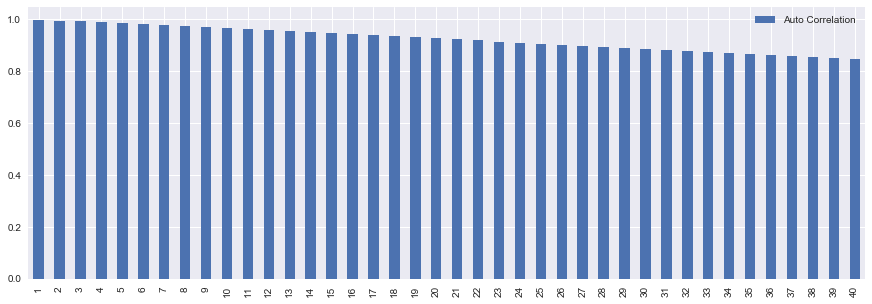

In [173]:
acf_1 = acf(df_arima_resampled)[1:365]
test_df = pd.DataFrame([acf_1]).T
test_df.columns = ['Auto Correlation']
test_df.index += 1
test_df.plot(kind='bar')
plt.show()

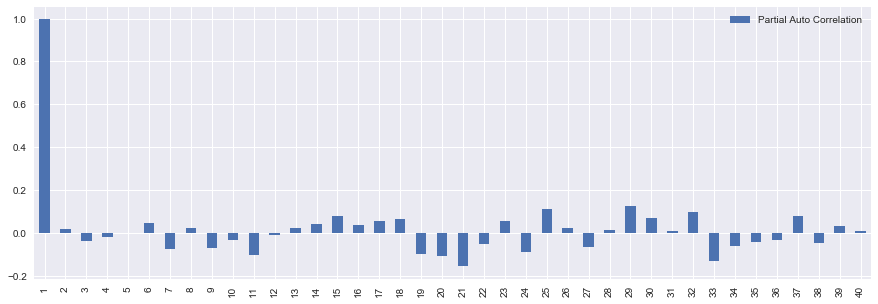

In [174]:
pacf_1 = pacf(df_arima_resampled)[1:365]
test_df = pd.DataFrame([pacf_1]).T
test_df.columns = ['Partial Auto Correlation']
test_df.index += 1
test_df.plot(kind='bar')
plt.show()

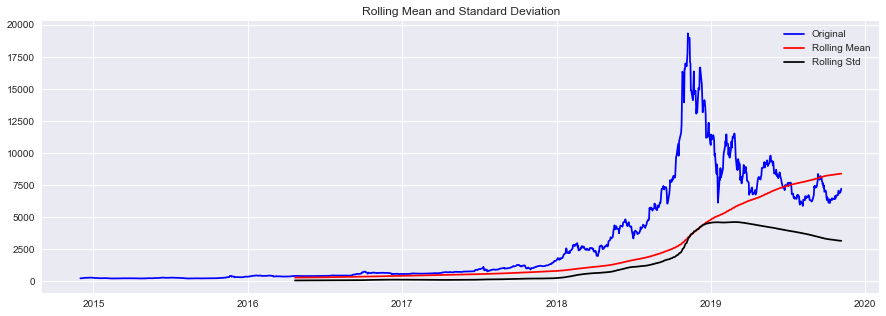

In [196]:
# Check rolling statistic : 
rolling_mean = df_arima_resampled.rolling(window=365).mean()
rolling_std = df_arima_resampled.rolling(window=365).std()
#rolling_mean.dropna(inplace=True)
#rolling_std.dropna(inplace=True)

#plot them
original = plt.plot(df_arima_resampled,color='blue',label='Original')
mean = plt.plot(rolling_mean,color='red',label='Rolling Mean')
std = plt.plot(rolling_std,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=True)

In [189]:
rolling_mean.head(10)

2014-12-08    243.556310
2014-12-09    246.464244
2014-12-10    249.401172
2014-12-11    255.164450
2014-12-12    261.210044
2014-12-15    266.341539
2014-12-16    269.379013
2014-12-17    273.013540
2014-12-18    275.639352
2014-12-19    277.009644
Freq: B, Name: denoised_data, dtype: float64

In [22]:
rolling_std.head(10)

2014-12-01   NaN
2014-12-02   NaN
2014-12-03   NaN
2014-12-04   NaN
2014-12-05   NaN
2014-12-08   NaN
2014-12-09   NaN
2014-12-10   NaN
2014-12-11   NaN
2014-12-12   NaN
Freq: B, Name: denoised_data, dtype: float64

In [23]:
#Common method for checking stationary and Dicky fuller test
def test_stationary(timeseries_local_df):
    movingaverge = timeseries_local_df.rolling(window=365).mean()
    movingstd = timeseries_local_df.rolling(window=365).std()
    
    #plot them
    original = plt.plot(timeseries_local_df,color='blue',label='Original')
    mean = plt.plot(movingaverge,color='red',label='Rolling Mean')
    std = plt.plot(movingstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=True)
    
    #A DFuller
    dftest = adfuller(timeseries_local_df,autolag='AIC')
    dfoutput= pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags used','No of Observation Used'])
    for key,value in  dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Data Trasformation -- To make time series stationary

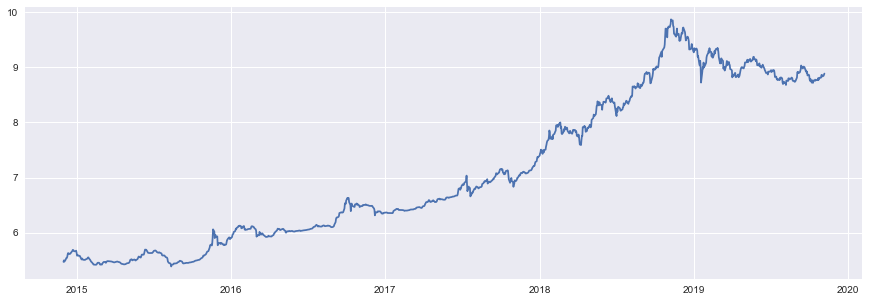

In [25]:
#Lets make the distribution more linear
#Estimate the trend Convert Data to logarithm
lnprice = np.log(df_arima_resampled)
plt.plot(lnprice)
plt.show()

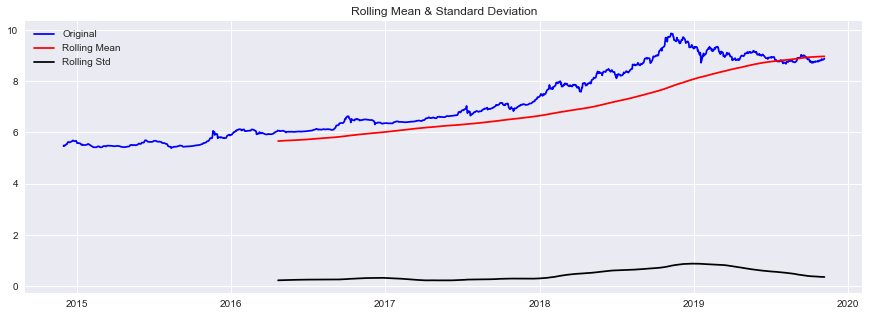

Test Statistics             -0.349331
p-value                      0.918221
#Lags used                   0.000000
No of Observation Used    1287.000000
Critical Value (1%)         -3.435441
Critical Value (5%)         -2.863788
Critical Value (10%)        -2.567967
dtype: float64


In [26]:
#Test stationary of log 
test_stationary(lnprice)

#### Smoothing by Rolling Average, Differencing and Transformation.

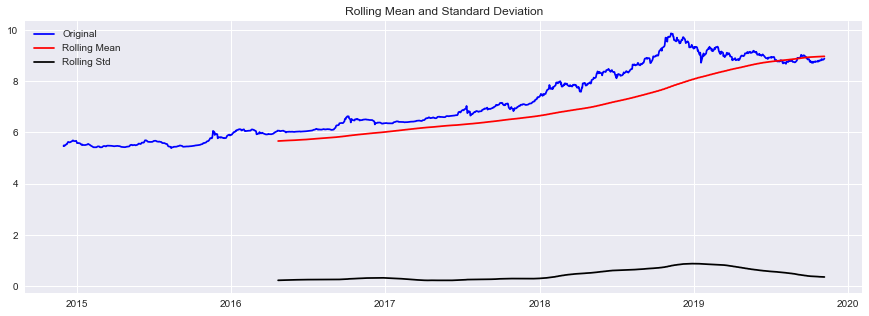

In [197]:
# Check rolling statistic : 
rolling_mean = lnprice.rolling(window=365).mean()
rolling_std = lnprice.rolling(window=365).std()
#rolling_mean.dropna(inplace=True)
#rolling_std.dropna(inplace=True)

#plot them
original = plt.plot(lnprice,color='blue',label='Original')
mean = plt.plot(rolling_mean,color='red',label='Rolling Mean')
std = plt.plot(rolling_std,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=True)

In [192]:
#Difference of moving average and actual
df_ln_price_minus_mean = lnprice - rolling_mean
df_ln_price_minus_mean.head(10) #NaN

df_ln_price_minus_mean.dropna(inplace=True)
df_ln_price_minus_mean.head(10)

2016-04-22    0.403838
2016-04-25    0.400879
2016-04-26    0.384232
2016-04-27    0.379228
2016-04-28    0.377892
2016-04-29    0.385100
2016-05-02    0.390334
2016-05-03    0.393604
2016-05-04    0.392082
2016-05-05    0.384363
Freq: B, Name: denoised_data, dtype: float64

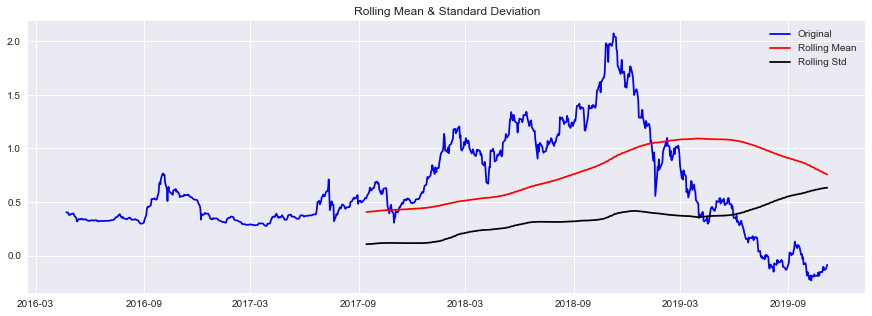

Test Statistics            -0.941413
p-value                     0.774029
#Lags used                  0.000000
No of Observation Used    923.000000
Critical Value (1%)        -3.437455
Critical Value (5%)        -2.864676
Critical Value (10%)       -2.568440
dtype: float64


In [198]:
#Verify the stationarity of the timeseries after data transformation
test_stationary(df_ln_price_minus_mean)

#### Still model needs improved so apply exponential weighted average

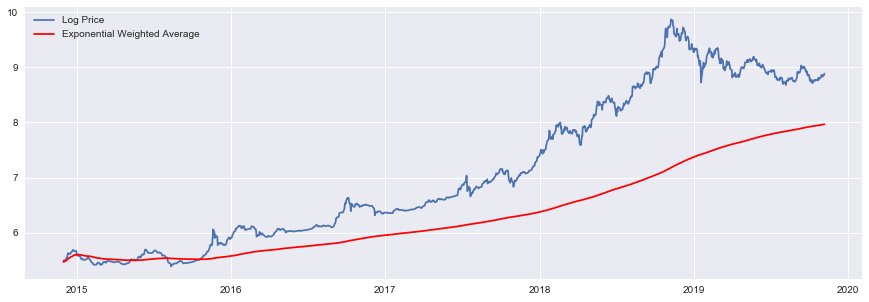

In [205]:
#Calculate weighted mean/average and compare
weighted_avg_arima_df = lnprice.ewm(halflife=365,min_periods=0,adjust=True).mean()
plt.plot(lnprice,label='Log Price')
plt.plot(weighted_avg_arima_df,color='red',label='Exponential Weighted Average')
plt.legend()
#weighted_avg_arima_df

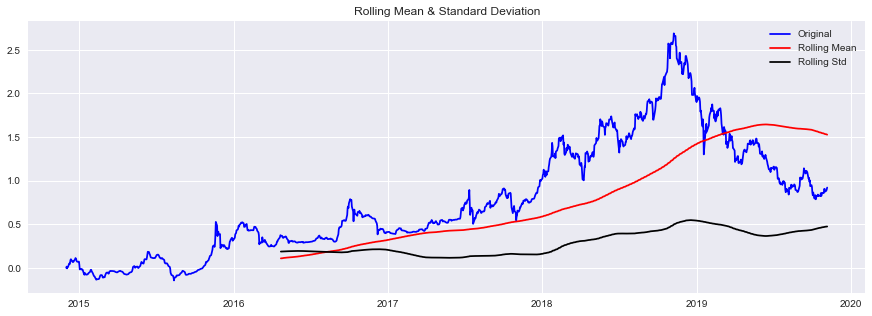

Test Statistics             -1.342632
p-value                      0.609450
#Lags used                   0.000000
No of Observation Used    1287.000000
Critical Value (1%)         -3.435441
Critical Value (5%)         -2.863788
Critical Value (10%)        -2.567967
dtype: float64


In [212]:
# Data shows Test statistic is much higher so data needs to be further transformed
arima_df_log_minus_exp_weighted_avg = lnprice - weighted_avg_arima_df
test_stationary(arima_df_log_minus_exp_weighted_avg)

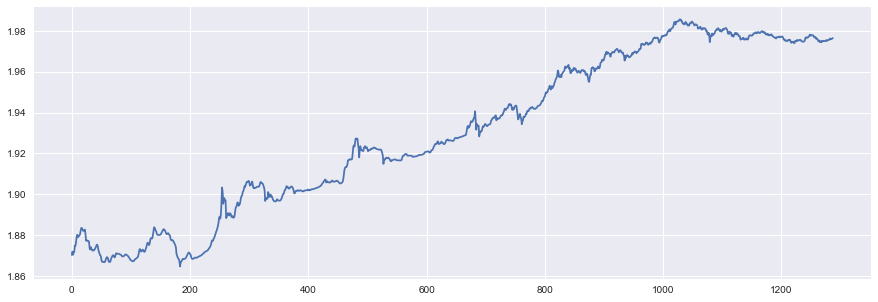

In [346]:
#Box and Cox transformation 
#df_arima_resampled
#lambda = -1. is a reciprocal transform.
#lambda = -0.5 is a reciprocal square root transform.
#lambda = 0.0 is a log transform.
#lambda = 0.5 is a square root transform.
#lambda = 1.0 is no transform.

df_arima_resampled_bc = boxcox(df_arima_resampled,lmbda=-0.5)
plt.plot(df_arima_resampled_bc)

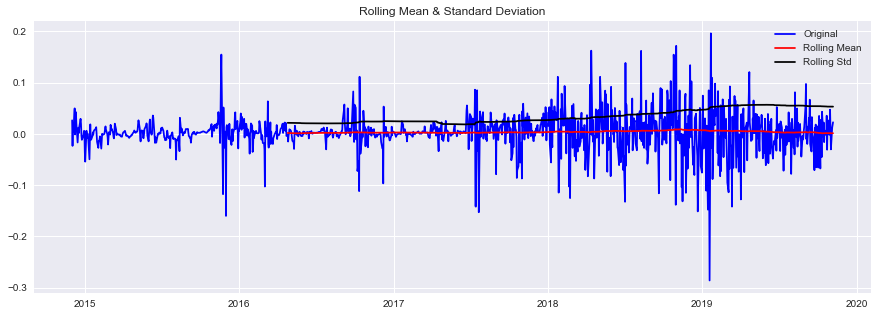

Test Statistics            -35.334166
p-value                      0.000000
#Lags used                   0.000000
No of Observation Used    1286.000000
Critical Value (1%)         -3.435445
Critical Value (5%)         -2.863790
Critical Value (10%)        -2.567968
dtype: float64


In [347]:
#Shifting and differencing the values

lnprice_shifted = lnprice - lnprice.shift(1)
#plt.plot(lnprice_shifted)
lnprice_shifted = lnprice_shifted.dropna()
test_stationary(lnprice_shifted.dropna())

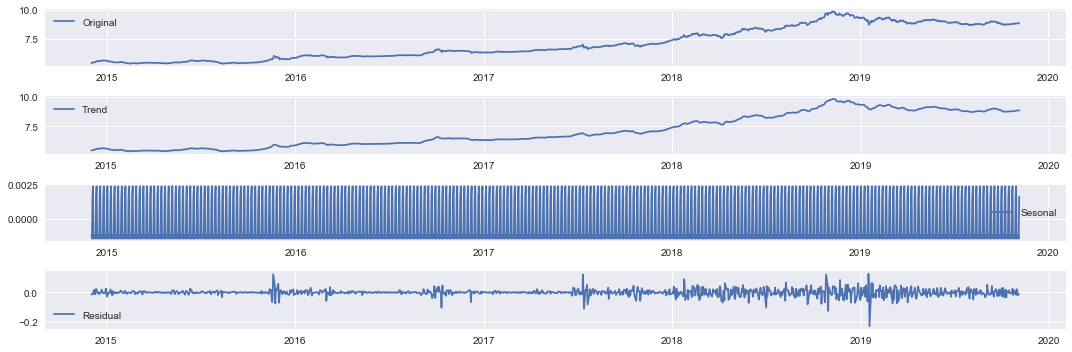

In [348]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(lnprice)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(lnprice,label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Sesonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')

plt.tight_layout()


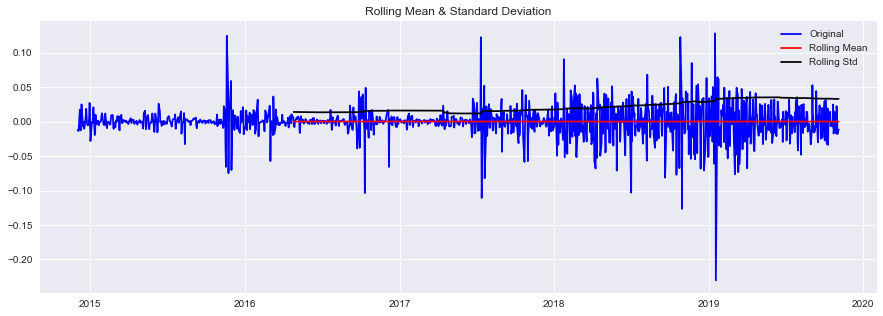

Test Statistics          -1.273858e+01
p-value                   9.047841e-24
#Lags used                2.000000e+01
No of Observation Used    1.263000e+03
Critical Value (1%)      -3.435538e+00
Critical Value (5%)      -2.863831e+00
Critical Value (10%)     -2.567990e+00
dtype: float64


In [349]:
#residual log
decomposed_log = residual
decomposed_log.dropna(inplace=True)
test_stationary(decomposed_log)

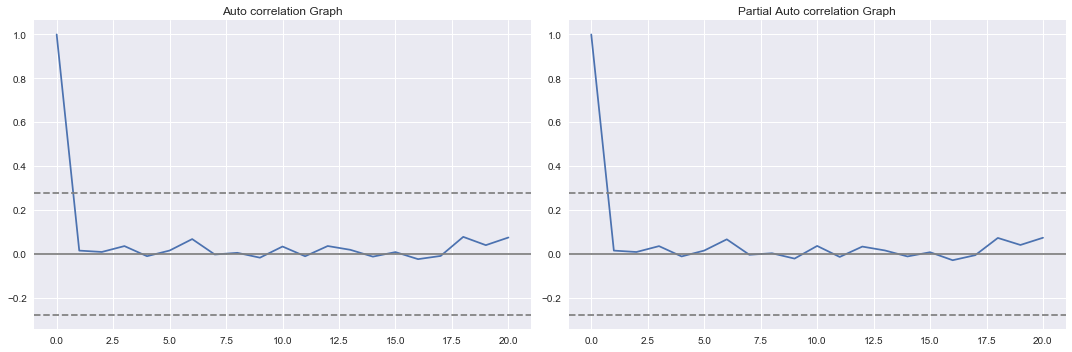

In [273]:
#ACF : for calculation of P
#acf_1 = acf(lnprice_shifted)[1:2000]
acf_1 = acf(lnprice_shifted, nlags=20)

plt.subplot(121)
plt.plot(acf_1)
plt.axhline(y=0,color='grey')
plt.axhline(y=-10/np.sqrt(len(lnprice_shifted)),linestyle='--',color='grey')
plt.axhline(y=10/np.sqrt(len(lnprice_shifted)),linestyle='--',color='grey')
plt.title('Auto correlation Graph')

#PACF for calculation of q
plt.subplot(122)
pacf_1 = pacf(lnprice_shifted,nlags=20,method='ols')
plt.plot(pacf_1)
plt.axhline(y=0,color='grey')
plt.axhline(y=-10/np.sqrt(len(lnprice_shifted)),linestyle='--',color='grey')
plt.axhline(y=10/np.sqrt(len(lnprice_shifted)),linestyle='--',color='grey')
plt.title('Partial Auto correlation Graph')

plt.tight_layout()


In [156]:
#### Apply ARIMA model
#### P and Q values from ACF and PACF grah
#### Q value from differencing 

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


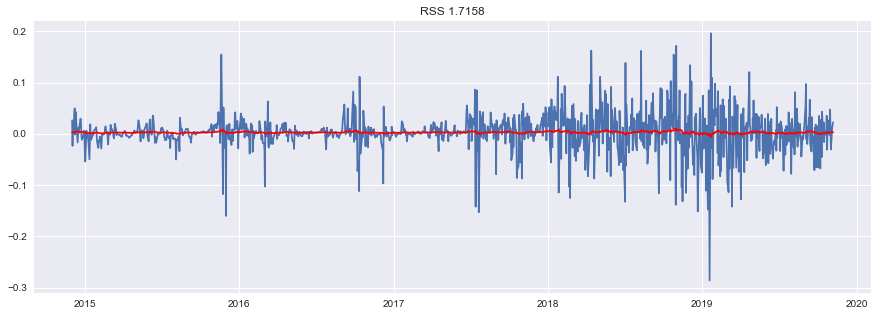

In [350]:
#AR
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(lnprice,order=(1,1,1))
results_ARIMA = model.fit(disp=-1)

plt.plot(lnprice_shifted)
plt.plot(results_ARIMA.fittedvalues,color='Red')
plt.title('RSS %.4f' % sum((results_ARIMA.fittedvalues - lnprice_shifted)**2))

In [351]:
#sampled_data
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.denoised_data   No. Observations:                 1287
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2433.915
Method:                       css-mle   S.D. of innovations              0.037
Date:                Tue, 27 Nov 2018   AIC                          -4859.829
Time:                        19:03:17   BIC                          -4839.189
Sample:                    12-02-2014   HQIC                         -4852.081
                         - 11-06-2019                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0027      0.001      2.198      0.028       0.000       0.005
ar.L1.D.denoised_data     0.9046      0.083     10.877      0.000       0.742       1.068
ma.L1.D.

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [352]:
#### Convert predictions back to our time series data format

In [353]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head(5))


#Convert Cummulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head(5))

2014-12-02    0.002669
2014-12-03    0.003144
2014-12-04    0.002569
2014-12-05    0.002852
2014-12-08    0.002843
Freq: B, dtype: float64
2014-12-02    0.002669
2014-12-03    0.005813
2014-12-04    0.008382
2014-12-05    0.011234
2014-12-08    0.014077
Freq: B, dtype: float64


In [354]:
#Predicted ARIMA
predicted_ARIMA_log = pd.Series(lnprice.iloc[0],index=lnprice.index)
predicted_ARIMA_log = predicted_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

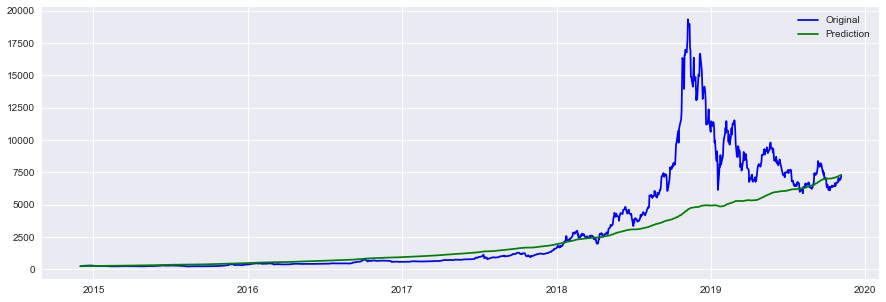

In [355]:
#Convert back to original form by taking exponential
predicted_ARIMA = np.exp(predicted_ARIMA_log)
plt.plot(df_arima_resampled,color='blue',label='Original')
plt.plot(predicted_ARIMA,color='green',label='Prediction')
plt.legend()

In [356]:
predicted_ARIMA_log.tail(5)

2019-10-31    8.884216
2019-11-01    8.887598
2019-11-04    8.890287
2019-11-05    8.893149
2019-11-06    8.896264
Freq: B, dtype: float64

In [357]:
df_arima_resampled.tail(5)

2019-10-31    7069.646972
2019-11-01    6858.181319
2019-11-04    6942.077625
2019-11-05    7064.659764
2019-11-06    7225.109815
Freq: B, Name: denoised_data, dtype: float64

In [358]:
lnprice.shape

(1288,)

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


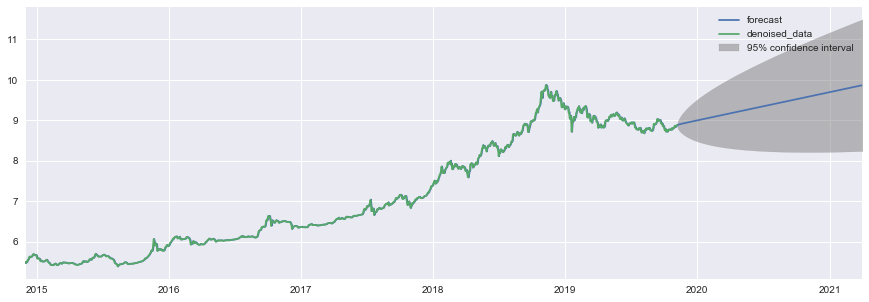

In [359]:
#Predict the future
results_ARIMA.plot_predict(1,1653)
x = results_ARIMA.forecast(steps=365)